<a href="https://colab.research.google.com/github/KushalGajjar1/Zero-Shot-and-Pruning-model/blob/main/Pruning_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -U fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 912.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=f4125c41f8aaeb3a6a727ddfcfcf699e168ecea811eebb2961b168826828a8a3
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=7c6288529165ab29ecd6ac0fd14f2fa82853f2bbbdd2227c06715bf5acd12f3a
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

from tqdm import tqdm

from fvcore.nn import parameter_count
from fvcore.nn import FlopCountAnalysis

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
def prune_filters(self,indices):

      conv_layer=0

      for layer_name, layer_module in self.named_modules():

        if(isinstance(layer_module, nn.Conv2d)):

          if(conv_layer==0):
            in_channels=[i for i in range(layer_module.weight.shape[1])]

          else:
            in_channels=indices[conv_layer-1]

          out_channels=indices[conv_layer]
          layer_module.weight = nn.Parameter(torch.FloatTensor(torch.from_numpy(layer_module.weight.data.cpu().numpy()[out_channels])))

          if layer_module.bias is not None:
            layer_module.bias = nn.Parameter(torch.FloatTensor(torch.from_numpy(layer_module.bias.data.cpu().numpy()[out_channels])).to(device))


          layer_module.weight = nn.Parameter(torch.FloatTensor(torch.from_numpy(layer_module.weight.data.numpy()[:,in_channels])).to(device))


          layer_module.in_channels=len(in_channels)
          layer_module.out_channels=len(out_channels)
          conv_layer+=1

        if (isinstance(layer_module, nn.BatchNorm2d)):
            out_channels=indices[conv_layer]

            layer_module.weight = nn.Parameter(torch.FloatTensor(torch.from_numpy(layer_module.weight.data.cpu().numpy()[out_channels])).to(device))
            layer_module.bias = nn.Parameter(torch.FloatTensor(torch.from_numpy(layer_module.bias.data.cpu().numpy()[out_channels])).to(device))

            layer_module.running_mean= torch.from_numpy(layer_module.running_mean.cpu().numpy()[out_channels]).to(device)
            layer_module.running_var=torch.from_numpy(layer_module.running_var.cpu().numpy()[out_channels]).to(device)

            layer_module.num_features= len(out_channels)

        if isinstance(layer_module, nn.Linear):
            conv_layer-=1
            in_channels=indices[conv_layer]

            weight_linear = layer_module.weight.data.cpu().numpy()

            size=7*7 # ======================================================================================================= hard coded
            expanded_in_channels=[]
            for i in in_channels:
              for j in range(size):
                expanded_in_channels.extend([i*size+j])

            layer_module.weight = nn.Parameter(torch.from_numpy(weight_linear[:,expanded_in_channels]).to(device))

            layer_module.in_features = len(expanded_in_channels)
            break

In [ ]:
def get_indices_bottomk(values,prune_limit):

      sorted_indices = sorted(range(len(values)), key=lambda k: values[k])
      non_pruned_indices = sorted_indices[prune_limit:]
      non_pruned_values = [values[i] for i in non_pruned_indices]

      return non_pruned_indices

In [ ]:
url = '/content/drive/MyDrive/Data_Tomato_Potato/Preprocessed_data/'

data_potato = np.load(url + 'Potato_LHE/data_Potato_LHE.npy')
label_potato = np.load(url + 'Potato_LHE/label_Potato_LHE.npy')

fake_data_potato = np.load(url + 'Potato_LHE/Fake_data_Potato_LHE_300.npy')
fake_label_potato = np.load(url + 'Potato_LHE/Fake_label_Potato_LHE_300.npy')

merge_data_potato = np.concatenate((data_potato, fake_data_potato))
merge_label_potato = np.concatenate((label_potato, fake_label_potato))

data_tomato = np.load(url + 'Tomato_LHE/data_Tomato_LHE.npy')
label_tomato = np.load(url + 'Tomato_LHE/label_Tomato_LHE.npy')

merge_data_potato_norm = merge_data_potato/np.max(merge_data_potato)
data_tomato_norm = data_tomato/np.max(data_tomato)

data_potato_tensor = torch.tensor(merge_data_potato_norm).float()
data_potato_tensor = torch.transpose(data_potato_tensor, 3, 1)

label_potato_tensor = torch.tensor(merge_label_potato).long()
print(label_potato_tensor.shape)

data_tomato_tensor = torch.tensor(data_tomato_norm).float()
data_tomato_tensor = torch.transpose(data_tomato_tensor, 3, 1)

label_tomato_tensor = torch.tensor(label_tomato).long()
print(label_tomato_tensor.shape)

train_data = data_tomato_tensor # data_potato_tensor
train_label = label_tomato_tensor # label_potato_tensor

test_data = data_potato_tensor # data_tomato_tensor
test_label = label_potato_tensor #label_tomato_tensor

train_data = TensorDataset(train_data,train_label)
test_data = TensorDataset(test_data,test_label)

torch.Size([3052])
torch.Size([4499])


In [ ]:
batchsize = 100

train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)

print(test_data.tensors[0].shape)
test_loader = DataLoader(test_data, batch_size=batchsize)

torch.Size([3052, 3, 64, 64])


In [ ]:
output = 3
epochs = 20

In [ ]:
def trainModel(model, optimizer, criterion):

    model.to(device)

    for epoch in range(epochs):

        train_acc = []

        for batch_num, (inputs, targets) in enumerate(train_loader):

            inputs = inputs.to(device)
            targets = targets.to(device)

            model.train()

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                y_hat = torch.argmax(output, 1)
                score = torch.eq(y_hat, targets).sum()
                train_acc.append((score.item()/batchsize)*100)

        with torch.no_grad():
            epoch_train_acc = np.mean(np.array(train_acc))

            test_acc = []

            model.eval()

            for batch_nums_test, (inputs_test, targets_test) in enumerate(test_loader):

                inputs_test = inputs_test.to(device)
                targets_test = targets_test.to(device)

                output_test = model(inputs_test)

                y_hat_test = torch.argmax(output_test, 1)
                score_test = torch.eq(y_hat_test, targets_test).sum()
                test_acc.append((score_test.item()/batchsize)*100)

            epoch_test_acc = np.mean(np.array(test_acc))


    return epoch_train_acc, epoch_test_acc

In [ ]:
def getTestAcc(model):

    test_acc = []
    model.eval()

    for batch_nums_test, (inputs_test, targets_test) in enumerate(test_loader):

        inputs_test = inputs_test.to(device)
        targets_test = targets_test.to(device)

        output_test = model(inputs_test)

        y_hat_test = torch.argmax(output_test, 1)
        score_test = torch.eq(y_hat_test, targets_test).sum()
        test_acc.append((score_test.item()/batchsize)*100)

    return np.mean(np.array(test_acc))

In [ ]:
def getGraph(valuesY, valuesX):

    x = np.array(valuesX)
    y = np.array(valuesY)

    plt.ylabel("Accuracy")
    plt.xlabel("Percent Pruned")
    plt.plot(x, y)
    plt.show()

In [ ]:
ActualModel = torchvision.models.vgg16(pretrained=True)
ActualModel.classifier[6] = nn.Linear(4096, output)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 72.8MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ActualModel.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_acc_before_pruning, test_acc_before_pruning = trainModel(ActualModel, optimizer, criterion)

In [ ]:
train_acc_before_pruning, test_acc_before_pruning

(99.97727272727273, 61.193548387096776)

In [ ]:
print(sum(p.numel() for p in ActualModel.parameters()))
total_params_original = parameter_count(ActualModel)[""]
print(f"Total parameters : {total_params_original}")

input = (torch.randn((1, 3, 224, 224)), )
flops_original = FlopCountAnalysis(ActualModel.to('cpu'), input)
total_original_flops = flops_original.total()
print(f"Total FLOPS : {total_original_flops}")

torch.save(ActualModel.state_dict(), 'TrainedModel.pt')

134272835
Total parameters : 134272835


Total FLOPS : 15466205696


In [ ]:
prune_limit = [[2, 2, 4, 4, 8, 8, 8, 16, 16, 16, 16, 16, 16],
               [4, 4, 8, 8, 16, 16, 16, 32, 32, 32, 32, 32, 32],
               [8, 8, 16, 16, 32, 32, 32, 64, 64, 64, 64, 64, 64],
               [16, 16, 32, 32, 64, 64, 64, 128, 128, 128, 128, 128, 128],
               [32, 32, 64, 64, 128, 128, 128, 256, 256, 256, 256, 256, 256]]

In [ ]:
percentageParameterPruned = []
percentageFLOPSPruned = []
parameters = []
FLOPS = []
testAccRetraining = []

for prune_limits in tqdm(prune_limit):

  model = torchvision.models.vgg16(pretrained=True)
  model.classifier[6] = nn.Linear(4096, output)
  model.load_state_dict(torch.load('TrainedModel.pt'))

  l1Norm = []

  for layer_name, layer_module in model.named_modules():
    if(isinstance(layer_module, nn.Conv2d)):
      temp= []
      filter_weight = layer_module.weight.clone()
      for k in range(filter_weight.size()[0]):
        temp.append(float("{:.6f}".format((filter_weight[k, :, :, :]).norm(1).item())))
      l1Norm.append(temp)

  layer_bound = l1Norm
  dec_indices = []

  for i in range(len(layer_bound)):
    temp = []
    temp = get_indices_bottomk(layer_bound[i], prune_limits[i])
    dec_indices.append(temp)

  prune_filters(model, dec_indices)

  total_params = parameter_count(model)[""]
  parameters.append(total_params)
  percentageParameterPruned.append(100-((total_params/total_params_original)*100))

  input = (torch.randn((1, 3, 224, 224)), )
  flops = FlopCountAnalysis(model.to('cpu'), input)
  total_flops = flops.total()
  FLOPS.append(total_flops)
  percentageFLOPSPruned.append(100-((total_flops/total_original_flops)*100))


  train_acc_retraining, test_acc_retraining = trainModel(model, optimizer, criterion)
  testAccRetraining.append(test_acc_retraining)

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 20%|██        | 1/5 [02:41<10:46, 161.66s/it]/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWa

In [ ]:
for i in range(len(percentageParameterPruned)):
  print(f"percent : {percentageParameterPruned[i]} Acc : {testAccRetraining[i]}")

percent : 3.065684879596091 Acc : 55.774193548387096
percent : 6.109974515694105 Acc : 64.25806451612904
percent : 12.134368057395974 Acc : 63.0
percent : 23.926412218822975 Acc : 50.193548387096776
percent : 46.48352885377002 Acc : 41.935483870967744


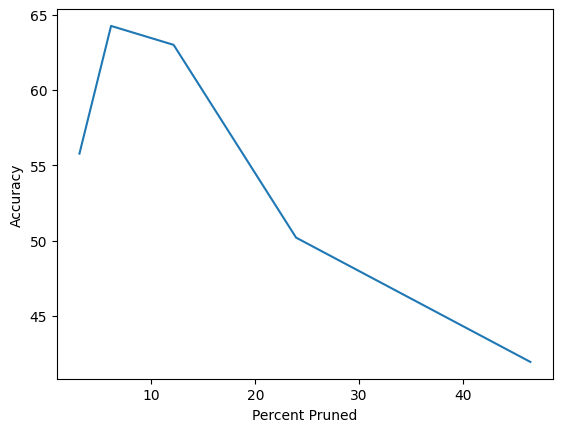

In [ ]:
getGraph(testAccRetraining, percentageParameterPruned)

In [ ]:
for i in range(len(percentageFLOPSPruned)):
  print(f"percent : {percentageFLOPSPruned[i]} Acc : {testAccRetraining[i]}")

percent : 6.108574440105514 Acc : 55.774193548387096
percent : 12.024441343625597 Acc : 64.25806451612904
percent : 23.278052540909385 Acc : 63.0
percent : 43.47278449645159 Acc : 50.193548387096776
percent : 74.61228665143443 Acc : 41.935483870967744


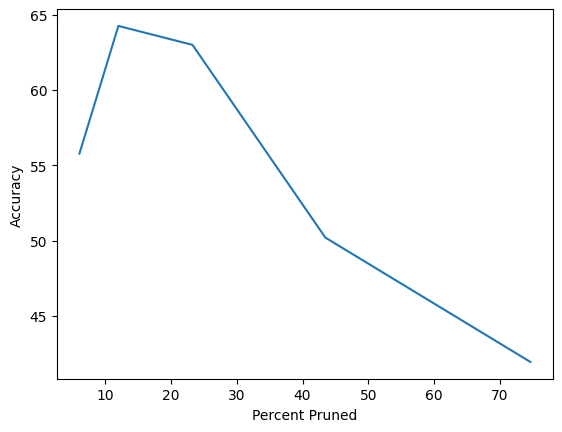

In [ ]:
getGraph(testAccRetraining, percentageFLOPSPruned)